# PC5 - Sélection de modèles et régularisation

Ce notebook aborde les notions de régularisation et de sélection de modèles :
- La régularisation consiste à imposer des contraintes supplémentaires à votre modèle pour lui éviter de surapprendre sur les données d'entraînement. Ici nous présentons les **régularisations L1 et L2** (partie 1).
- La sélection de modèle consiste à élaborer des protocoles d'évaluation robustes pour comparer les performances de différents modèles sur un problème donné. La technique utilisée est celle de la **validation croisée** (partie 2).
- Un problème concret sur une base de données réelle permet de mettre en applications les concepts introduits (partie 3).

Enfin, de part les exemples présentés, une variante de la régression linéaire est présentée : la **régression polynomiale**. 

Ce notebook vous est proposé par [Arthur Imbert](https://github.com/Henley13).

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import scipy

Ce notebook a été créé avec les versions suivantes : 
- numpy==1.18.3
- matplotlib==3.1.1
- pandas==1.0.3
- sklearn==0.23.1
- scipy==1.3.1

Des différences de version peuvent expliquer des comportements inattendus (avertissements, messages d'erreurs, fonctionalités inexistantes) mais il n'est pas nécessaire a priori d'avoir exactement les versions listées ci-dessus. 

In [2]:
# check your versions
print("numpy=={0}".format(np.__version__))
print("matplotlib=={0}".format(matplotlib.__version__))
print("pandas=={0}".format(pd.__version__))
print("sklearn=={0}".format(sklearn.__version__))
print("scipy=={0}".format(scipy.__version__))

numpy==1.18.3
matplotlib==3.2.1
pandas==1.0.3
sklearn==0.23.0
scipy==1.4.1


In [3]:
# set font size in plots
plt.rc('font', **{'size': 12})

## 1. Régularisation

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

Un modèle complexe a plus de chance de surapprendre. C'est le cas par exemple si vous avez un grand nombre de variables ou plusieurs paramètres à optimiser pour faire fonctionner le modèle. En général, la régularisation prend la forme d'un terme additionel dans la fonction de perte qui pénalise les modèles complexes. L'idée est d'introduire volontairement un biais dans le modèle pour le rendre plus robuste. Nous préférons un modèle un peu moins précis sur les données d'entraînement, mais capable de conserver le même niveau de performance sur de nouvelles données de test. 

Nous allons utiliser dans ce notebook deux méthodes parmi les plus couramment utilisées pour régulariser les modèles linéaires :
- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) cf. Section 8.5 du poly
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) cf. Section 8.6 du poly

### 1.1 Régularisation L2 (Ridge)

La **régularisation L2** appliquée à une régression linéaire (également appelé **régression Ridge**) consiste à résoudre le problème convexe suivant :

$$
    \underset{\beta \in \mathbb{R}^{p+1}}{\arg\min} \lVert y - X\beta \rVert^2_2 + \lambda \lVert \beta \rVert^2_2
$$

Le terme $\lVert \beta \rVert^2_2$ pénalise les valeurs extrêmes de $\beta$. Intuitivement nous pouvons voir que cette contrainte va inciter le modèle à ne pas trop se spécialiser " la solution n'associe pas des poids exagérés à des dimensions de $X$ qui permettrait éventuellement de prédire parfaitement les données d'entraînement. 

Le paramètre $\lambda$ permet d'accorder plus ou moins d'importance à votre terme de régularisation. 

Pour illustrer l'impact d'une régularisation Ridge, nous allons simuler un jeu de données non linéaire qui prendra la forme d'une courbe sinusoïdale.

In [5]:
nb_samples = 30

# set the random seed to generate the same random numbers
np.random.seed(13)

# ground truth function such that y = f(X)
def f(X):
    return np.cos(1.5 * np.pi * X) * 5

# compute ground truth distribution
X_gt = np.linspace(0, 1, 100).reshape(-1, 1)
y_gt = f(X_gt)
print(X_gt.shape, y_gt.shape)

# simulate random samples from this distribution
X = np.sort(np.random.rand(nb_samples, 1))
y = f(X)

# add noise
y += np.random.randn(nb_samples, 1) * 0.3
print(X.shape, y.shape)

(100, 1) (100, 1)
(30, 1) (30, 1)


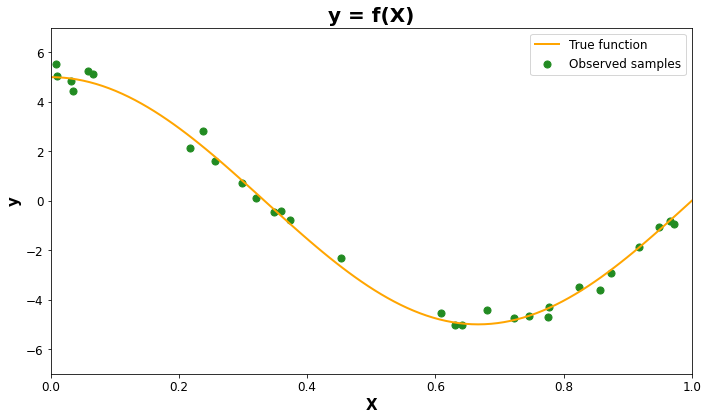

In [6]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot ground truth function f
plt.plot(X_gt, y_gt, label="True function", c="orange", linewidth=2)

# plot samples
plt.scatter(X, y, label="Observed samples", c="forestgreen", marker="o", s=50)

# format plot
plt.xlabel("X", fontweight="bold", fontsize=15)
plt.ylabel("y", fontweight="bold", fontsize=15)
plt.xlim((0, 1))
plt.ylim((-7, 7))
plt.title("y = f(X)", fontweight="bold", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Nous proposons 3 méthodes pour estimer au mieux cette courbe à partir d'une "droite" de régression :
- Une régression linéaire
- Une régression polynomiale
- Une régression polynomiale régularisée

In [7]:
# split dataset for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(21, 1) (21, 1)
(9, 1) (9, 1)


#### 1.1.1 Linear regression

__Question :__ Combien de *features* avons-nous dans notre problème ?

__Réponse :__ 1

Entrainons une régression linéaire « classique » (comme celle vue à la PC3) sur `(X_train, y_train)` et évaluons sa performance d'une part sur le jeu d'entraînement et d'autre part sur le jeu de test. 

__Question :__ Pourquoi comparer ces deux performances ?

__Réponse :__ Pour évaluer si le modèle sous apprend ou au contraire sur apprend

In [8]:
# train model
reg = LinearRegression()
reg.fit(X_train, y_train)

# adjusted R2
print("adjusted R2")
r2_score_reg_train = r2_score(y_train, reg.predict(X_train))
print("\r train: {0:0.2f}".format(r2_score_reg_train))

r2_score_reg_test = r2_score(y_test, reg.predict(X_test))
print("\r test: {0:0.2f}".format(r2_score_reg_test))

# mean squared error
print("root mean squared error")
rmse_reg_train = mean_squared_error(y_train, reg.predict(X_train), squared=False)
print("\r train: {0:0.2f}".format(rmse_reg_train))

rmse_reg_test = mean_squared_error(y_test, reg.predict(X_test), squared=False)
print("\r test: {0:0.2f}".format(rmse_reg_test))

adjusted R2
 train: 0.63
 test: 0.74
root mean squared error
 train: 2.08
 test: 1.91


__Question :__ Que pouvez-vous conclure sur le choix de la régression linéaire ?

__Réponse :__ R2 < 0.9 dans les deux cas -> pas linéaire
amplitude de variation de y : 12, meab squared error = 1/6 de ca : bcp trop

In [9]:
# interpolate regression line
y_model = reg.predict(X_gt)

Nous allons maintenant afficher le modèle appris sur le graphe précédent.

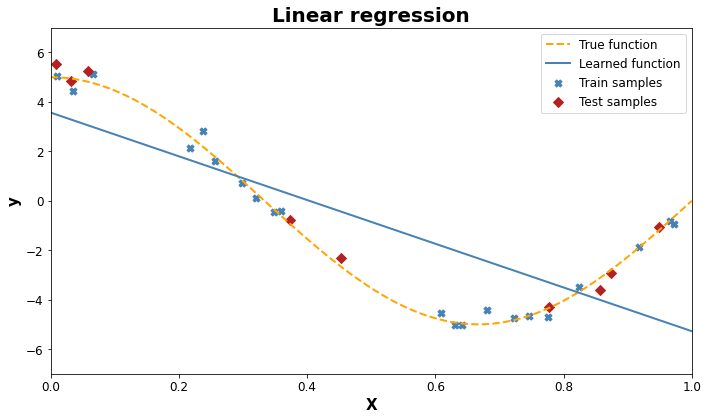

In [10]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot ground truth function f
plt.plot(X_gt, y_gt, '--', label="True function", c="orange", linewidth=2)

# plot regression line
plt.plot(X_gt, y_model, label="Learned function", c="steelblue", linewidth=2)

# plot train and test samples
plt.scatter(X_train, y_train, label="Train samples", c="steelblue", marker="X", s=50)
plt.scatter(X_test, y_test, label="Test samples", c="firebrick", marker="D", s=50)

# format plot
plt.xlabel("X", fontweight="bold", fontsize=15)
plt.ylabel("y", fontweight="bold", fontsize=15)
plt.xlim((0, 1))
plt.ylim((-7, 7))
plt.title("Linear regression", fontweight="bold", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

__Question :__ Le graphique est-il cohérent avec les performances calculées ?

__Réponse :__ erreur moyenne de 2 : ok, modèle tout pourri

#### 1.1.2 Régression polynomiale 

La régression polynomiale consiste à apprendre un modèle non-linéaire en apprenant un modèle linéaire sur un nouvel ensemble de variables, formé de monomes des variables décrivant nos données.

De manière générale, pour un problème décrit par $p$ variables $(X_1, X_2, \dots, X_p)$, une régression polynomiale de degré $d$ est une régression linéaire sur les variables $(X_1, X_2, \dots, X_p, X_1^2, X_1 X_2, \dots, X_p^2, \dots, X_p^d)$. Remarquez que nous créons ainsi un grand nombre de variables, corrélées entre elles ; nous gagnons en finesse de modélisation, mais perdons en complexité du modèle, risque de surapprentissage, et fléau de la dimension. Nous parlerons plus de modèles non-linéaires au chapitre 9. 

Une telle transformation est possible avec la classe `PolynomialFeatures` de `sklearn.preprocessing`.

Ici, il s'agit donc de régresser une droite à partir des puissances de $X$ et non plus de $X$ uniquement. Dans notre exemple, $\beta$ n'est plus un scalaire mais un vecteur associant un coefficient à $X^1$, $X^2$, $X^3$, ..., $X^{15}$. On approxime $y$ comme un polynôme de $X$.

In [11]:
# compute polynomial features
polynomial_features = PolynomialFeatures(degree=15, include_bias=False)

X_train_polynomial = polynomial_features.fit_transform(X_train)
X_test_polynomial = polynomial_features.transform(X_test)
X_gt_polynomial = polynomial_features.transform(X_gt)

print(X_train_polynomial.shape)
print(X_test_polynomial.shape)
print(X_gt_polynomial.shape)

(21, 15)
(9, 15)
(100, 15)


__Question :__ Combien de *features* avons-nous dans notre problème ?

__Réponse :__ 15

In [12]:
# train model
reg = LinearRegression()
reg.fit(X_train_polynomial, y_train)

# adjusted R2
print("adjusted R2")
r2_score_reg_train = r2_score(y_train, reg.predict(X_train_polynomial))
print("\r train: {0:0.2f}".format(r2_score_reg_train))
r2_score_reg_test = r2_score(y_test, reg.predict(X_test_polynomial))
print("\r test: {0:0.2f}".format(r2_score_reg_test))

# root mean squared error
print("root mean squared error")
rmse_reg_train = mean_squared_error(y_train, reg.predict(X_train_polynomial), squared=False)
print("\r train: {0:0.2f}".format(rmse_reg_train))
rmse_reg_test = mean_squared_error(y_test, reg.predict(X_test_polynomial), squared=False)
print("\r test: {0:0.2f}".format(rmse_reg_test))

# interpolate regression line
y_model = reg.predict(X_gt_polynomial)

adjusted R2
 train: 1.00
 test: 0.92
root mean squared error
 train: 0.17
 test: 1.10


__Question :__ Que pouvez-vous conclure sur le choix de la régression polynomiale ?

__Réponse :__ parfait (presque) pour données d'entraînement mais un peu moins bien pour données de test. Surapprentissage

Nous allons maintenant comparer le modèle appris à la vérité terrain (la fonction qui nous a servi à simuler les données).

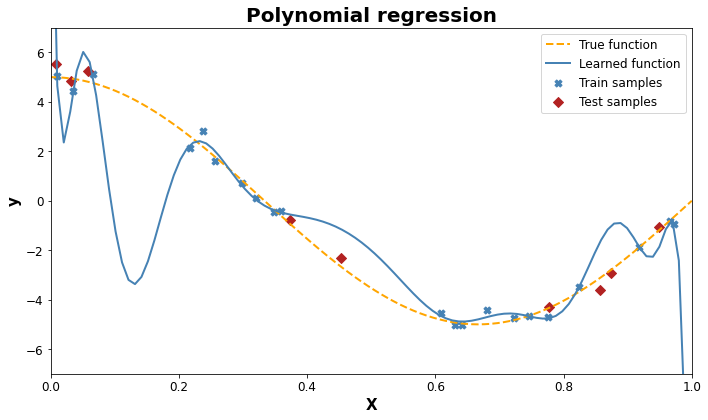

In [13]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot ground truth function f
plt.plot(X_gt, y_gt, '--', label="True function", c="orange", linewidth=2)

# plot regression line
plt.plot(X_gt, y_model, label="Learned function", c="steelblue", linewidth=2)

# plot train and test samples
plt.scatter(X_train, y_train, label="Train samples", c="steelblue", marker="X", s=50)
plt.scatter(X_test, y_test, label="Test samples", c="firebrick", marker="D", s=50)

# format plot
plt.xlabel("X", fontweight="bold", fontsize=15)
plt.ylabel("y", fontweight="bold", fontsize=15)
plt.xlim((0, 1))
plt.ylim((-7, 7))
plt.title("Polynomial regression", fontweight="bold", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

__Question :__ Le graphique est-il cohérent avec les performances calculées ?

__Réponse :__ non, si on calculait les performances sur l'intégralité de la fonction elles seraient médiocres

#### 1.1.3 Régression polynomiale régularisée ridge

Comme la régression polynomiale surapprend, nous allons maintenant lui appliquer un terme de régularisation ridge pour essayer de compenser cet effet.

In [14]:
# train model
ridge = Ridge(alpha=0.01, random_state=13)
ridge.fit(X_train_polynomial, y_train)

# adjusted R2
print("adjusted R2")
r2_score_ridge_train = r2_score(y_train, ridge.predict(X_train_polynomial))
print("\r train: {0:0.2f}".format(r2_score_ridge_train))
r2_score_ridge_test = r2_score(y_test, ridge.predict(X_test_polynomial))
print("\r test: {0:0.2f}".format(r2_score_ridge_test))

# mean squared error
print("root mean squared error")
rmse_ridge_train = mean_squared_error(y_train, ridge.predict(X_train_polynomial), squared=False)
print("\r train: {0:0.2f}".format(rmse_ridge_train))
rmse_ridge_test = mean_squared_error(y_test, ridge.predict(X_test_polynomial), squared=False)
print("\r test: {0:0.2f}".format(rmse_ridge_test))

# interpolate regression line
y_model = ridge.predict(X_gt_polynomial)

adjusted R2
 train: 0.99
 test: 0.99
root mean squared error
 train: 0.38
 test: 0.30


__Question :__ Que pouvez-vous conclure sur le choix du Ridge ?

__Réponse :__ un peu moins bien sur données d'entrainement (même si carrément propre) mais bcp bcp mieux sur données de test, moins de surapprentissage, très bon choix

Comparons le modèle que nous venons d'apprendre à la fonction nous ayant permi de simuler les données :

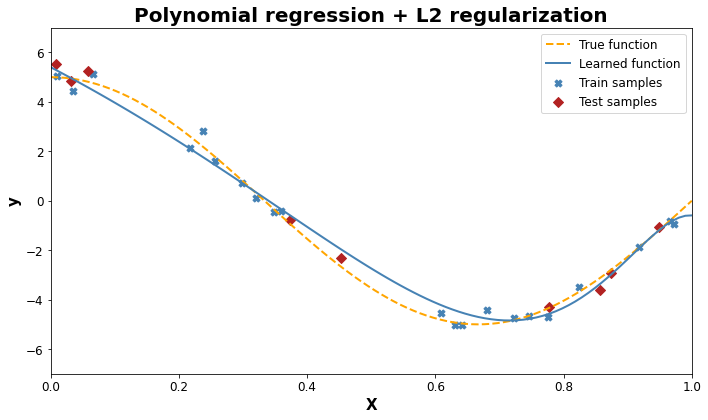

In [15]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot ground truth function f
plt.plot(X_gt, y_gt, '--', label="True function", c="orange", linewidth=2)

# plot regression line
plt.plot(X_gt, y_model, label="Learned function", c="steelblue", linewidth=2)

# plot train and test samples
plt.scatter(X_train, y_train, label="Train samples", c="steelblue", marker="X", s=50)
plt.scatter(X_test, y_test, label="Test samples", c="firebrick", marker="D", s=50)

# format plot
plt.xlabel("X", fontweight="bold", fontsize=15)
plt.ylabel("y", fontweight="bold", fontsize=15)
plt.xlim((0, 1))
plt.ylim((-7, 7))
plt.title("Polynomial regression + L2 regularization", fontweight="bold", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

__Question :__ Avec la régression polynomiale, était-il possible d'éviter le surapprentissage sans utiliser la régularisation L2 ? 

__Réponse :__ régularisation L1

### 1.2 Régularization L1 (Lasso)

La **régularisation L1** appliquée à une régression linéaire (également appelé **régression Lasso**) consiste à résoudre le problème suivant :

$$
    \underset{\beta \in \mathbb{R}^{p+1}}{\arg\min} \lVert y - X\beta \rVert^2_2 + \lambda \lVert \beta \rVert_1
$$

L'impact de la pénalisation L1 est plus radical que celui de la pénalisation L2. Le terme $\lVert \beta \rVert_1$ pénalise tous les coefficients non nuls. Cette contrainte va inciter le modèle à mettre à zéro les coefficients des variables les moins influentes. La solution est dite parcimonieuse ou *sparse* (un nombre limité de coefficients non nuls). Le paramètre $\lambda$ permet d'accorder plus ou moins d'importance à votre terme de régularisation. 

Pour illustrer l'impact d'une régularisation Lasso, nous allons simuler un jeu de données parcimonieux à approximer.

In [16]:
nb_samples = 100
nb_features = 200
noise_ratio = 0.1

# set the random seed to generate the same random numbers
np.random.seed(13)

# sample random multidimensional input
X = np.random.randn(nb_samples, nb_features)

# decreasing coefficients with alternated signs for visualization
idx = np.arange(nb_features)
beta = (-1) ** idx * np.exp(-idx / 10)

# sparsify coefficients
beta[10:] = 0

# target variable
y = np.dot(X, beta)

# add noise
y += np.random.randn(nb_samples) * noise_ratio
print(X.shape, y.shape)

(100, 200) (100,)


Visualisons notre modèle :

0.05


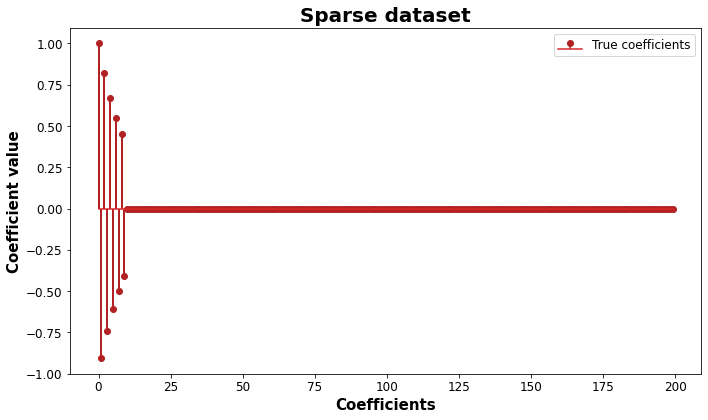

In [18]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot ground truth coefficient values
nonzero_coef_id = np.where(beta)[0]
nonzero_coef_value = beta[beta != 0]
m, s, _ = plt.stem(idx, beta, 
                   markerfmt='o', label='True coefficients', use_line_collection=True)
plt.setp([m, s], color="firebrick", linewidth=2)

# format plot
plt.xlabel("Coefficients", fontweight="bold", fontsize=15)
plt.ylabel("Coefficient value", fontweight="bold", fontsize=15)
plt.title("Sparse dataset", fontweight="bold", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
print(len(nonzero_coef_id)/200)
plt.show()

__Question :__ Quelle est la proportion de coefficients non nuls utilisées pour simuler les données ?

__Réponse :__ 0.05

Ici la difficulté pour l'apprentissage vient de ce qu'une grande partie de notre jeu de données n'a pas d'influence sur notre variable d'intérêt $y$. A nouveau, nous commençons par entraîner une régression linéaire afin de comparer les résultats avec le Lasso.

In [19]:
# split dataset for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70, 200) (70,)
(30, 200) (30,)


#### 1.2.1 Régression linéaire

In [20]:
# train model
reg = LinearRegression()
reg.fit(X_train, y_train)

# adjusted R2
print("adjusted R2")
r2_score_reg_train = r2_score(y_train, reg.predict(X_train))
print("\r train: {0:0.2f}".format(r2_score_reg_train))
r2_score_reg_test = r2_score(y_test, reg.predict(X_test))
print("\r test: {0:0.2f}".format(r2_score_reg_test))

# mean squared error
print("root mean squared error")
rmse_reg_train = mean_squared_error(y_train, reg.predict(X_train), squared=False)
print("\r train: {0:0.2f}".format(rmse_reg_train))
rmse_reg_test = mean_squared_error(y_test, reg.predict(X_test), squared=False)
print("\r test: {0:0.2f}".format(rmse_reg_test))

adjusted R2
 train: 1.00
 test: 0.28
root mean squared error
 train: 0.00
 test: 1.89


__Question :__ Que pouvez-vous conclure sur le choix de la régression linéaire ?

__Réponse :__ surapprentissage

#### 1.2.2 Régression linéaire régularisée Lasso

__Code :__ Entrainez une régression Lasso (paramètre de régularisation `alpha=0.1`) sur les données d'entraînement. Reportez-vous à la documentation : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html (l'API est similaire à celle de la régularisation ridge).

Calculez le R2 ajusté et la *RMSE* sur les données d'entraînement et de test.

In [25]:
# train model
lasso = Lasso(alpha = 0.1)
lasso.fit(X_train,y_train)
Y_test_pred = lasso.predict(X_test)
Y_train_pred = lasso.predict(X_train)

# adjusted R2
print("adjusted R2")
r2_score_lasso_train = r2_score(y_train, Y_train_pred)
print("\r train: {0:0.2f}".format(r2_score_reg_train))
r2_score_lasso_test = r2_score(y_test, Y_test_pred)
print("\r test: {0:0.2f}".format(r2_score_reg_test))

# mean squared error
print("root mean squared error")
rmse_lasso_train = mean_squared_error(y_train, Y_train_pred, squared=False)
print("\r train: {0:0.2f}".format(rmse_reg_train))
rmse_lasso_test = mean_squared_error(y_test, Y_test_pred, squared=False)
print("\r test: {0:0.2f}".format(rmse_reg_test))

adjusted R2
 train: 0.98
 test: 0.97
root mean squared error
 train: 0.34
 test: 0.39


__Question :__ Que pouvez-vous conclure sur le choix du Lasso ?

__Réponse :__ c'est mieux même si ici on gagnerait peut etre à avoir un modèle poly

Nous allons maintenant visualiser les coefficients du modèle appris par le Lasso : 

13


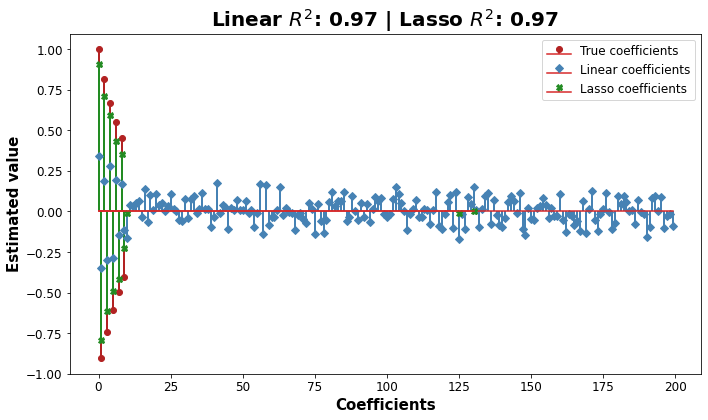

In [27]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot ground truth coefficient values
nonzero_coef_id = np.where(beta)[0]
nonzero_coef_value = beta[beta != 0]
m, s, _ = plt.stem(nonzero_coef_id, nonzero_coef_value, 
                   markerfmt='o', label='True coefficients', use_line_collection=True)
plt.setp([m, s], color="firebrick", linewidth=2)

# plot linear coefficient values
nonzero_coef_id = np.where(reg.coef_)[0]
nonzero_coef_value = reg.coef_[reg.coef_ != 0]
m, s, _ = plt.stem(nonzero_coef_id, nonzero_coef_value, 
                   markerfmt='D', label='Linear coefficients', use_line_collection=True)
plt.setp([m, s], color="steelblue", linewidth=2)

# plot Lasso coefficient values
nonzero_coef_id = np.where(lasso.coef_)[0]
nonzero_coef_value = lasso.coef_[lasso.coef_ != 0]
m, s, _ = plt.stem(nonzero_coef_id, nonzero_coef_value, 
                   markerfmt='X', label='Lasso coefficients', use_line_collection=True)
plt.setp([m, s], color="forestgreen", linewidth=2)

# format plot
plt.xlabel("Coefficients", fontweight="bold", fontsize=15)
plt.ylabel("Estimated value", fontweight="bold", fontsize=15)
title_str = "Linear $R^2$: {0:0.2f} | Lasso $R^2$: {01:0.2f}".format(r2_score_reg_test, r2_score_lasso_test)
plt.title(title_str, fontweight="bold", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
print(len(nonzero_coef_id))
plt.show()

__Question :__ Combien de variables sont utilisées par le modèle lasso ?

__Réponse :__ 13

__Question :__ Comment expliquer les mauvaises performances de la régression linéaire (non régularisée) ?

__Réponse :__ surapprentissage

## 2. Sélection de modèle

In [28]:
from sklearn.model_selection import KFold, cross_validate, GridSearchCV

Notre objectif est de sélectionner le meilleur modèle pour un problème donné. Pour comparer différent modèles nous utilisons un ou plusieurs critères de performance sur un jeu de données que l'on aurait exclue dès le début de l'analyse (le jeu de test).

En particulier, nous avons utilisé une valeur fixe du coefficient de régularisation (`alpha` dans `scikit-learn`, $\lambda$ dans le poly). Rien ne garantit que cette valeur soit optimale.

Jusqu'à maintenant, séparer les observations en jeu d'entraînement et de test suffisait à entraîner et évaluer les modèles. Cependant, pour des problèmes plus complexes nécessitant des modèles plus élaborées, une préparation des données en amont et un traitement particulier des résultats en aval, il est très facile de surapprendre sur les données de test elles-mêmes ! Vous risquez d'optimisez votre chaîne d'analyse (le poids $\lambda$ de la régularisation, le choix des variables à conserver, etc.) afin de maximiser les performances sur un jeu de test qui n'est plus totalement inconnu. Une solution est de séparer vos observations initiales en trois jeux de données : **entraînement** (pour entraîner les modèles), **validation** (pour sélectionner le meilleur modèle et optimiser ses paramètres) et **test** (pour évaluer).

La **validation croisée** permet d'aller plus loin et de répéter les séparations *entraînement/test* ou *entraînement/validation/test* à partir du même jeu d'observations. Les mesures de performances moyennées sur ces différentes séparations sont plus robustes. 

Reportez-vous à la section 8.2 du poly pour ces notions. 

`sklearn` propose différentes variantes de la validation croisée :
- [K-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) : la validation croisée telle que nous l'avons vue dans le poly
- [Stratified K-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) : même chose, mais pour les problèmes de classification, en faisant en sorte que la proportion d'exemples de chaque classe soit respectée dans chaque fold

(Pour aller plus loin)
- [Leave-One-Out](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) : autant de folds que d'échantillons ; requiert donc d'entrainer $n$ modèles (ce qui est coûteux en ressources) et a l'inconvénient de produire des modèles très similaire les uns aux autres (leurs jeux d'entrainement différant d'une seule observation) qui, étant testés sur une observation à la fois, peuvent donner une grande variance dans l'estimation de l'erreur de généralisation. Elle est ainsi peu utilisée, sauf cas particulier.
- [Leave-P-Out](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePOut.html) : chaque sous ensemble de taille $P$ du jeu de données est utilisé comme jeu de test (et le reste comme jeu d'entrainement) ; on obtient ainsi un grand nombre de modèles (ce qui peut être très coûteux en ressources) et des jeux de tests non disjoints (contrairement à la validation croisée). Relativement peu utilisé aussi.



Pour la suite, nous utilisons le même jeu de données parcimonieux que pour le Lasso. La validation croisée permet une évaluation plus robuste de notre modèle, mais également d'optimiser le paramètre de régularisation $\lambda$.

#### Pour générer de nouveau le jeu de données si besoin

In [31]:
nb_samples = 100
nb_features = 200
noise_ratio = 0.1

# set the random seed to generate the same random numbers
np.random.seed(13)

# sample random multidimensional input
X = np.random.randn(nb_samples, nb_features)

# decreasing coefficients with alternated signs for visualization
idx = np.arange(nb_features)
beta = (-1) ** idx * np.exp(-idx / 10)

# sparsify coefficients
beta[10:] = 0

# target variable
y = np.dot(X, beta)

# add noise
y += np.random.randn(nb_samples) * noise_ratio
print(X.shape, y.shape)

(100, 200) (100,)


### 2.1 Validation croisée

En utilisant `sklearn.model_selection.train_test_split` et `sklearn.model_selection.KFold` nous isolons un jeu de test dès le début, puis nous tirons aléatoirement K *folds* d'entraînement et de validation.

In [32]:
# define different train-validation-test splits
X_train_, X_test, y_train_, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
print("nb_test: {1}".format(len(X_train_), len(X_test)), "\n")
kf = KFold(n_splits=5, shuffle=True, random_state=13)

# loop over the different folds
scores = []
for i, (train_index, validation_index) in enumerate(kf.split(X_train_)):
    print("fold: {0} | nb_train: {1} | nb_validation: {2}".format(i, len(train_index), len(validation_index)))

    # get train and validation dataset
    X_train = X_train_[train_index]
    X_validation = X_train_[validation_index]
    y_train = y_train_[train_index]
    y_validation = y_train_[validation_index]
    
    # preprocess data
    # ...
    
    # train model
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train, y_train)

    # postprocess results
    # ...
    
    # measure performance (here, adjusted R2)
    r2_score_lasso_validation = r2_score(y_validation, lasso.predict(X_validation))
    scores.append(r2_score_lasso_validation)
    print("\r adjusted R2 (validation): {0:0.3f}".format(r2_score_lasso_validation))
    
print()

# performance on the validation set
average_score = np.mean(scores)
std_score = np.std(scores)
print("Average adjusted R2 (validation): {0:0.3f}".format(average_score))
print("Standard deviation adjusted R2 (validation): {0:0.3f}".format(std_score), "\n")

# performance on the test set
r2_score_lasso_test = r2_score(y_test, lasso.predict(X_test))
print("Adjusted R2 (test): {0:0.3f}".format(r2_score_lasso_test))

nb_test: 20 

fold: 0 | nb_train: 64 | nb_validation: 16
 adjusted R2 (validation): 0.968
fold: 1 | nb_train: 64 | nb_validation: 16
 adjusted R2 (validation): 0.954
fold: 2 | nb_train: 64 | nb_validation: 16
 adjusted R2 (validation): 0.957
fold: 3 | nb_train: 64 | nb_validation: 16
 adjusted R2 (validation): 0.975
fold: 4 | nb_train: 64 | nb_validation: 16
 adjusted R2 (validation): 0.958

Average adjusted R2 (validation): 0.963
Standard deviation adjusted R2 (validation): 0.008 

Adjusted R2 (test): 0.977


Plus simplement, on peut directement calculer une métrique de performance en moyennant plusieurs folds avec `sklearn.model_selection.cross_validate`.

In [33]:
# define a model
lasso = Lasso(alpha=0.1, random_state=13, max_iter=10000)

# compute an average adjusted R2 score over 5 different train-test folds
cv_results = cross_validate(lasso, X, y, cv=5, return_train_score=True, scoring="r2")
print("Average adjusted R2 (test): {0:0.3f}".format(np.mean(cv_results["test_score"])))
print("Standard deviation adjusted R2 (test): {0:0.3f}".format(np.std(cv_results["test_score"])))
cv_results

Average adjusted R2 (test): 0.968
Standard deviation adjusted R2 (test): 0.008


{'fit_time': array([0.00751853, 0.00400138, 0.00200081, 0.00299358, 0.00299835]),
 'score_time': array([0.00099945, 0.00200081, 0.00199914, 0.00100327, 0.0020566 ]),
 'test_score': array([0.97035359, 0.95935982, 0.98196194, 0.96788181, 0.96188386]),
 'train_score': array([0.97197039, 0.97409888, 0.97965853, 0.97387514, 0.97917604])}

__Question :__ Selon vous, qu'est-ce qui pourrait expliquer la différence de performance entre les méthodes présentées (la première avec `sklearn.model_selection.KFold` et la seconde avec `sklearn.model_selection.cross_validate`) ?

__Réponse :__ n'utilisent pas la même méthode de séparation des données

__Code :__ Vous allez coder une validation croisée sur 5 *folds* en séparant les données entre entraînement et test seulement.

In [42]:
# define different train-test splits
n = len(X)//5

scores = []
# loop over the different folds
for i in range(5):
    test_ind = np.arange(i*n,n*(i+1),1)
    train_ind = np.array(list(set(np.arange(0,len(X),1)) - set(test_ind))) 
    
    X_test = X[test_ind]
    X_train = X[train_ind]
    y_test = y[test_ind]
    y_train = y[train_ind]
    lasso.fit(X_train,y_train)
    y_pred = lasso.predict(X_test)
    r2_score_lasso_test = r2_score(y_test, lasso.predict(X_test))
    scores.append(r2_score_lasso_test)
    

# performance on the test set
print(np.mean(scores))
print(np.std(scores))

0.9682882056364355
0.00790105909175332


### 2.2 *Gridsearch*

Le **_gridsearch_** consiste à évaluser les performances pour différentes valeurs de paramètres sur différents *folds* de validation croisée afin de retourner le paramètre optimal. La fonction d'usage est `sklearn.model_selection.GridSearchCV`. Dans notre exemple il s'agit d'optimiser le paramètre `alpha` du modèle Lasso.

In [43]:
# define model and alpha values to evaluate
lasso = Lasso(random_state=13, max_iter=10000)
alphas = np.logspace(-4, -1, 30)

# define gridsearch
tuned_parameters = [{'alpha': alphas}]
nb_folds = 5
grid = GridSearchCV(lasso, tuned_parameters, cv=nb_folds, refit=False)

# run gridsearch
grid.fit(X, y)

# get adjusted R2 (default score with Lasso models)
scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

# compute standard errors
std_error = scores_std / np.sqrt(nb_folds)

__Code :__ A partir des résultats du *gridsearch*, récupérez la valeur `alpha` optimale ainsi que la performance maximale.

In [46]:
# get optimal alpha
ind_max = scores.argmax()
score_max = scores.max()
print(alphas[ind_max])
print(score_max)

0.011721022975334805
0.9959880328304296


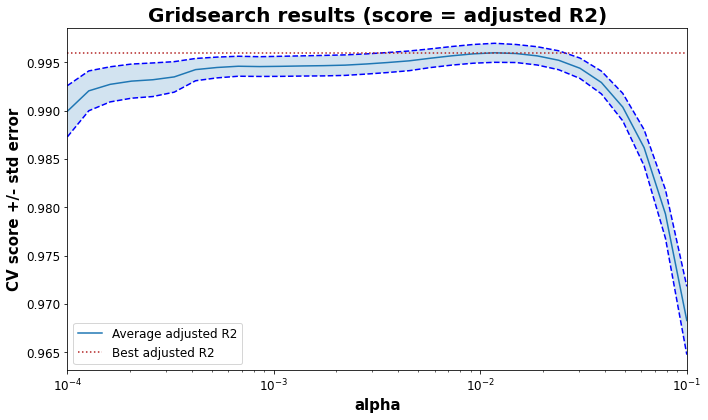

In [47]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot scores with a log scale in x-axis
plt.semilogx(alphas, scores, label="Average adjusted R2")
plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# control the translucency of the fill color with alpha=0.2
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

# plot best score
plt.axhline(np.max(scores), linestyle=':', color="firebrick", label="Best adjusted R2")

# format plot
plt.xlabel("alpha", fontweight="bold", fontsize=15)
plt.ylabel("CV score +/- std error", fontweight="bold", fontsize=15)
plt.xlim([alphas[0], alphas[-1]])
plt.title("Gridsearch results (score = adjusted R2)", fontweight="bold", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

__Question :__ Que voudrais dire une valeur de `alpha` proche de 0 ? Une valeur proche de 1 ?

__Réponse :__ proche de 0 : lasso pas important 1 : full lasso

A ce stade, vous pouvez entraîner votre modèle optimal en utilisant ensemble vos données d'entraînement et de validation. 

## 3. Cas pratique (bonus)

Pour ce cas pratique nous utilisons des données cliniques. L'objectif est de **prédire le niveau d'antigène prostatique spécifique** (a.k.a. *PSA* pour *Prostate-Specific Antigen*). C'est une protéine produite exclusivement par la prostate. Un taux de concentration élevé de cette molécule dans le sang est souvent le signe chez l'homme d'un cancer de la prostate. Cet indicateur permet ainsi de suivre l'évolution du cancer.

Plus précisément, nous allons essayer de prédire le niveau de concentration du *PSA* (`lpsa`, en échelle logarithmique) à partir des mesures cliniques suivantes :
- `cavol` : Le volume de la tumeur (échelle logarithmique).
- `lweight` : Le poids de la prostate (échelle logarithmique).
- `age`: L'âge du patient.
- `lbph`: Le volume de l'hypertrophie bénigne de la prostate (a.k.a. *BPH* pour *Benign Prostatic Hyperplasia*) qui correspond au volume non cancéreux de l'organe (échelle logarithmique).
- `svi`: Indicateur sur le fait que le cancer s'est propagé aux vésicules séminales (deux glandes associées à la prostate).
- `lcp`: La *pénétration capsulaire* qui mesure à quel point la capsule prostatique (la membrane qui entoure la prostate), a été envahi par le cancer (échelle logarithmique).
- `gleason`: Le score *Gleason*. Ce score est établi par un histopathologiste après observation d'une biopsie de la prostate. Pour plus d'information vous pouvez consulter ce lien : http://www.wikiwand.com/en/Gleason_grading_system. 
* `pgg45`: Le pourcentage de la tumeur qui est accrédité d'un score *Gleason* de 4 ou 5.

Ce jeu de données est un jeu de données classique, que l'on trouve par exemple [sur Kaggle](https://www.kaggle.com/tvscitechtalk/prostatecsv). Il est issu de Stamey, T.A., Kabalin, J.N., McNeal, J.E., Johnstone, I.M., Freiha, F., Redwine, E.A. and Yang, N. (1989). Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate: II. radical prostatectomy treated patients, _Journal of Urology_ 141(5), 1076–1083.


Nous avons bien ici un problème de **régression**.

In [ ]:
# load dataset
path = "../../data/prostate.csv"
df = pd.read_csv(path, index_col=0)
print(df.shape)
df.head()

### 3.1 Baseline

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df.loc[:, ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"]].to_numpy()
y = df.loc[:, "lpsa"].to_numpy()
print(X.shape, y.shape)

In [ ]:
# split dataset for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
# normalised data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)
print(X_train_normalized.shape)
print(X_test_normalized.shape)

In [ ]:
# define a model
reg = LinearRegression()

# compute an average adjusted R2 score over 5 different train-test folds
cv_results = cross_validate(reg, X_train_normalized, y_train, cv=5, return_train_score=True, 
                            scoring="neg_mean_squared_error")

# get MSE
print("Mean Squared Error (validation set): {0:0.3f}".format(-np.mean(cv_results["test_score"])))

### 3.2 Recherche du meilleur modèle

#### 3.2.1 Linear regression + Ridge

In [ ]:
# define model and alpha values to evaluate
model = None
alphas = np.logspace(-4, 4, 30)

# define gridsearch with negative mean squared error (NMSE)
# ...

# run gridsearch
# ...

# get NMSE
# ...

# compute standard errors for NMSE
# ...

# get optimal alpha
# ...

# Transform NMSE into MSE
# Attention : ici on reste avec la MSE plutôt que la RMSE car sklearn nous a donné les écarts-types sur la MSE 
# et la transformation de ces écarts-types en écarts-types de la RMSE n'est pas triviale.
# ...

In [ ]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot scores with a log scale in x-axis
plt.semilogx(alphas, scores, label="Average RMSE")
plt.semilogx(alphas, (scores + std_error), 'b--')
plt.semilogx(alphas, (scores - std_error), 'b--')

# control the translucency of the fill color with alpha=0.2
plt.fill_between(alphas, (scores + std_error), (scores - std_error), alpha=0.2)

# plot best score
plt.axhline(np.max(scores), linestyle=':', color="firebrick", label="Best MSE")

# format plot
plt.xlabel(r"$\alpha$", fontweight="bold", fontsize=15)
plt.ylabel("CV score +/- std error", fontweight="bold", fontsize=15)
plt.xlim([alphas[0], alphas[-1]])
plt.title("Gridsearch results (score = MSE)", fontweight="bold", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Coefficients du modèle

Le paramètre `refit=True` assure que `grid.best_estimator_` contient un modèle de régression ridge, de paramètre optimal, entrainé sur l'ensemble du jeu de données passé à `grid.fit`.

In [ ]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot best estimator coefficients
m, s, _ = plt.stem(np.arange(len(grid.best_estimator_.coef_)), grid.best_estimator_.coef_, 
                   markerfmt='o', label='Ridge', use_line_collection=True)
plt.setp([m, s], linewidth=2)

# format plot
plt.xlabel("Variables", fontsize=15)
plt.xticks(np.arange(len(grid.best_estimator_.coef_)), labels=list(df.columns[:-1]))

plt.ylabel("Coefficient de régression", fontsize=15)
plt.title("Ridge optimisée en validation croisée", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### 3.2.1 Linear regression + Lasso

In [ ]:
# define model
# ...

# define gridsearch
# ...

In [ ]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot scores with a log scale in x-axis
plt.semilogx(alphas, scores, label="Average MSE")
plt.semilogx(alphas, (scores + std_error), 'b--')
plt.semilogx(alphas, (scores - std_error), 'b--')

# control the translucency of the fill color with alpha=0.2
plt.fill_between(alphas, (scores + std_error), (scores - std_error), alpha=0.2)

# plot best score
plt.axhline(max(scores), linestyle=':', color="firebrick", label="Best MSE")

# format plot
plt.xlabel(r"$\alpha$", fontweight="bold", fontsize=15)
plt.ylabel("CV score +/- std error", fontweight="bold", fontsize=15)
plt.xlim([alphas[0], alphas[-1]])
plt.title("Gridsearch results (score = MSE)", fontweight="bold", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Coefficients du modèle

Le paramètre `refit=True` assure que `grid.best_estimator_` contient un Lasso, de paramètre optimal, entrainé sur l'ensemble du jeu de données passé à `grid.fit`.

In [ ]:
# initialize plot frame
plt.figure(figsize=(10, 6))

# plot best estimator coefficients
m, s, _ = plt.stem(np.arange(len(grid.best_estimator_.coef_)), grid.best_estimator_.coef_, 
                   markerfmt='o', label='Lasso', use_line_collection=True)
plt.setp([m, s], linewidth=2)

# format plot
plt.xlabel("Variables", fontsize=15)
plt.xticks(np.arange(len(grid.best_estimator_.coef_)), labels=list(df.columns[:-1]))

plt.ylabel("Coefficient de régression", fontsize=15)
plt.title("Lasso optimisé en validation croisée", fontsize=20)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

__Question :__ Quel est le meilleur modèle prédictif ? Quelles sont les variables les plus utiles pour la prédiction du PSA ?

__Réponse :__ 